# Li building PP from OEPP rho with PBE with TF02vW

In [1]:
from dftpy.ions import Ions
from dftpy.field import DirectField
from dftpy.grid import DirectGrid
from dftpy.functional import LocalPseudo, Functional, TotalFunctional
from dftpy.formats import io
from dftpy.optimization import Optimization
from dftpy.mpi import sprint
from dftpy.functional.pseudo.psp import PSP
from dftpy.constants import environ

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
# from scipy.signal import quadratic

In [3]:
from ase.build import molecule
from ase.atoms import Atoms
from ase.io import read

In [4]:
atoms = read('../../../KS/PBE/rho_ks_Li_oepp.xsf')

In [5]:
ions, rho_ks, _ = io.read_all('../../../KS/PBE/rho_ks_Li_oepp.xsf')
grid = rho_ks.grid


In [6]:
# 'S': '/projectsn/mp1009_1/Valeria/Batteries/Li2S_interface/OF/PP/S_OEPP_PZ.UPF',
PP_list = {'Li': '/projectsn/mp1009_1/Valeria/Batteries/Li2S_interface/OF/PP/Li_OEPP_PZ.UPF'}

In [7]:
# MaxPoints=1000
PSEUDO = LocalPseudo(grid = grid, ions=ions, PP_list=PP_list)#, MaxPoints=MaxPoints)
rho_ini =rho_ks.copy()
core = PSEUDO.core_density

setting key: Li -> /projectsn/mp1009_1/Valeria/Batteries/Li2S_interface/OF/PP/Li_OEPP_PZ.UPF


In [8]:
KE = Functional(type='KEDF',name='TFvW', y=0.2)
XC = Functional(type='XC',name='PBE', core_density=core)
HARTREE = Functional(type='HARTREE')

In [9]:
evaluator = TotalFunctional(KE=KE, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)

In [10]:
optimization_options = {'econv' : 1e-11*ions.nat}
opt = Optimization(EnergyEvaluator=evaluator, optimization_options = optimization_options, optimization_method = 'CG')
rho = opt.optimize_rho(guess_rho=rho_ks)

Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       -3.417850929806E-01     -3.417851E-01   1.299501E-03    1       1       2.857049E-01    
1       -3.422575401143E-01     -4.724471E-04   4.563562E-04    1       2       5.213299E-01    
2       -3.423054271972E-01     -4.788708E-05   1.871051E-03    1       3       8.762701E-01    
3       -3.423314137857E-01     -2.598659E-05   1.617624E-03    1       3       1.210968E+00    
4       -3.423502393048E-01     -1.882552E-05   1.399289E-03    1       3       1.539229E+00    
5       -3.423778939796E-01     -2.765467E-05   2.128479E-03    1       3       1.890752E+00    
6       -3.424021884243E-01     -2.429444E-05   1.720725E-03    1       3       2.229291E+00    
7       -3.424252623646E-01     -2.307394E-05   1.624440E-03    1       3       2.571049E+00    
8       -3.424451609098E-01     -1.989855E-05   1.540681E-03    1       3       2.906492E+00    
9       -3.424658575606E-01   

In [11]:
delta = 0.5 * np.abs(rho_ks - rho).integral()

In [12]:
delta

0.02772220600661851

In [13]:
kfmax=( np.max(rho) * 3 * np.pi )**(1.0/3.0)+0.2

In [14]:
from dftpy.mixer.pulay import PulayMixer

In [15]:
from dftpy.optimization import OESCF

In [16]:
pulay=PulayMixer(mp=None)

In [17]:
opt_options = {'econv' : 1e-6}

In [18]:
vW = Functional(type='KEDF', name='vW')
evaluator = TotalFunctional(KE=vW, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)

kedf_emb = Functional(type='KEDF',name='LMGP')#, kfmax=kfmax, kfmin=1e-10, ratio=1.02)
kedf_emb.options.update({'y':0})
evaluator_emb = TotalFunctional(KEDF_EMB = kedf_emb)

opt = Optimization(EnergyEvaluator=evaluator, optimization_options = opt_options, optimization_method = 'CG')
opt = OESCF(optimization=opt, evaluator_emb=evaluator_emb, guess_rho=rho,mixer=pulay)

In [19]:
rho_lmgp = opt.optimize_rho(guess_rho=rho_ks, econv=1e-6)

Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       -2.724200793630E-01     -2.724201E-01   1.686588E-05    1       1       5.621862E-02    
1       -2.724202886760E-01     -2.093130E-07   1.614523E-05    1       2       2.887526E-01    
2       -2.724203230810E-01     -3.440496E-08   8.832802E-06    1       3       6.352923E-01    
#### Density Optimization Converged ####
Chemical potential (a.u.): 0.004436683304133033
Chemical potential (eV)  : 0.1207283020566291
 OESCF--> iter=1     conv=1.000E-03 de=3.411E-01 energy=-3.410752E-01 time=8.281964E+00
Step    Energy(a.u.)            dE              dP              Nd      Nls     Time(s)         
0       -2.724257630749E-01     -2.724258E-01   6.801767E-06    1       1       6.927872E-02    
1       -2.724257780595E-01     -1.498467E-08   8.631917E-06    1       3       4.841647E-01    
2       -2.724258061097E-01     -2.805014E-08   7.641039E-06    1       2       7.865818E-01    
#

In [20]:
delta = 0.5 * np.abs(rho_ks - rho_lmgp).integral()
print(delta)

3.9114293530136895e-05


Text(0.5, 1.0, 'OF LMGP')

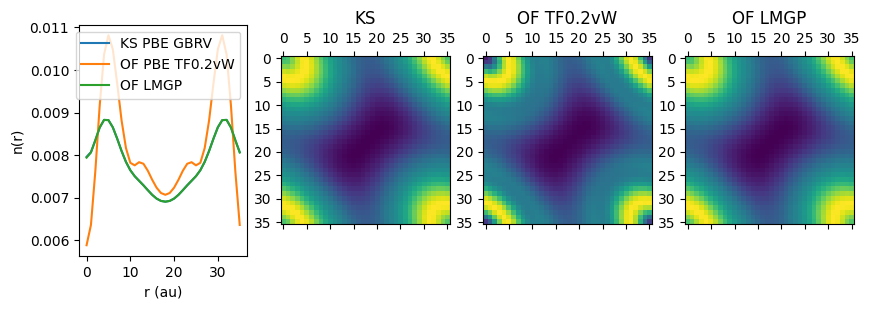

In [21]:
fig, axs = plt.subplots(1, 4, figsize=(10, 3))
r = np.linspace(0,ions.cell[2][2],len(rho_ks[0,0,:].ravel()))
cut = 0
axs[0].plot(rho_ks[:,cut,cut].ravel(), label='KS PBE GBRV')
axs[0].plot(rho[:,cut,cut].ravel(), label='OF PBE TF0.2vW')
axs[0].plot((rho_lmgp[:,cut,cut]).ravel(), label='OF LMGP')
axs[0].legend()
axs[0].set_ylabel('n(r)')
axs[0].set_xlabel('r (au)')

axs[1].matshow(rho_ks[cut,:,:])
axs[1].set_title('KS')
axs[2].matshow(rho[cut,:,:])
axs[2].set_title('OF TF0.2vW')
axs[3].matshow(rho_lmgp[cut,:,:])
axs[3].set_title('OF LMGP')

In [22]:
rho.write('rho_TF02vW_Li.xsf', ions=ions)
rho_lmgp.write('rho_LMGP_Li.xsf', ions=ions)

### PP optimitization

In [23]:
def delta_pp(r, rcut, a):
    d = r - rcut
    b = (3*a[0]*rcut-4*a[1]*rcut**2+5*a[2]*rcut**3)/2.0
    v = b*d**2 + a[0]*d**3 + a[1]*d**4+a[2]*d**5
    v[r>rcut] = 0.0
    return v

# def delta_pp(r, a):
#     rcut = a[3]
#     d = r - rcut
#     b = (3*a[0]*rcut-4*a[1]*rcut**2+5*a[2]*rcut**3)/2.0
#     v = b*d**2 + a[0]*d**3 + a[1]*d**4+a[2]*d**5
#     v[r>rcut] = 0.0
#     return v

def lpp2vloc(r, v, ions, grid, key, zval=0.0):
    engine = PSP(None)
    engine.r = r
    engine.v = v
    engine._zval = zval
    pseudo = LocalPseudo(grid = grid, ions=ions, PP_list={key:engine})#, MaxPoints=MaxPoints)
    pseudo.local_PP()
    return pseudo._vreal

In [32]:
key='Li'
grid = rho_ks.grid
rcut = 2.0 # Taken from the GBRV PP cutoff radius
r = np.linspace(0, rcut, 100)
a = [2.27533306e-02, 1.65398109e-05,6.93881439e-07]# np.zeros(3)
# KE = Functional(type='KEDF',name='LMGP', kfmax=kfmax, kfmin=1e-10, ratio=1.02)
KE = Functional(type='KEDF',name='TFvW', y=0.2)
evaluator = TotalFunctional(KE=KE, XC=XC, HARTREE=HARTREE, PSEUDO=PSEUDO)
ext = Functional(type='EXT')
evaluator.UpdateFunctional(newFuncDict={'EXT': ext})
optimization_options = {'econv' : 1e-11*ions.nat}
opt = Optimization(EnergyEvaluator=evaluator,optimization_options = optimization_options, optimization_method = 'CG')

rho_ini = rho_ks.copy()
environ['LOGLEVEL'] = 4
def delta_rho(a):
    print('Init')
    v = delta_pp(r, rcut, a)
    ext.v = lpp2vloc(r, v, ions, grid, key)
    rho = opt.optimize_rho(guess_rho=rho_ini)
    # rho_ini[:]=rho
    diff = 0.5 * (np.abs(rho - rho_ks)).integral()
    # if i%50==0 and i>1:
    print('aa:', a, diff)
    return diff

In [25]:
res = minimize(delta_rho, a, method='Powell', options={'ftol': 1.0e-4})


Init
aa: [0. 0. 0.] 0.02772220600661851
Init
aa: [0. 0. 0.] 0.02772220600661851
Init
aa: [1. 0. 0.] 0.18770800685112096
Init
aa: [-1.618034  0.        0.      ] 0.8980218107328661
Init
aa: [0. 0. 0.] 0.02772220600661851
Init
aa: [-0.61803397  0.          0.        ] 0.7341626075431306
Init
aa: [0.381966 0.       0.      ] 0.13527070871344554
Init
aa: [0.09216101 0.         0.        ] 0.04882759190331108
Init
aa: [-0.23606797  0.          0.        ] 0.2942950554866405
Init
aa: [-0.09016994  0.          0.        ] 0.10903860821864067
Init
aa: [0.0276183 0.        0.       ] 0.020156760804116724
Init
aa: [0.0313861 0.        0.       ] 0.02143779323892099
Init
aa: [0.02081129 0.         0.        ] 0.019542643307981576
Init
aa: [0.022305 0.       0.      ] 0.019484074580523373
Init
aa: [0.02252805 0.         0.        ] 0.01948295005445252
Init
aa: [0.02275333 0.         0.        ] 0.01948248006678253
Init
aa: [0.02461158 0.         0.        ] 0.019551079763841128
Init
aa: [0.0229808

In [26]:
environ['LOGLEVEL'] = 2

In [36]:
a = res.x
np.save('a_pbe_tf02vw', a)

In [34]:
a = res.x
key = 'Li'
r = PSEUDO.readpp.pp[key].r
zval = PSEUDO.readpp.pp[key]._zval
vl = PSEUDO.readpp.pp[key].v
v = delta_pp(r, rcut, a)
v += vl

engine = PSP(None)
engine.r = r
engine.v = v
engine.info['atomicnum'] = 3
engine._zval = zval

In [38]:
engine.write('POEPP_PBE_TF02vW.psp8')

Text(0.5, 1.0, 'Li LPP from OEPP rho with PBE with TF02vW')

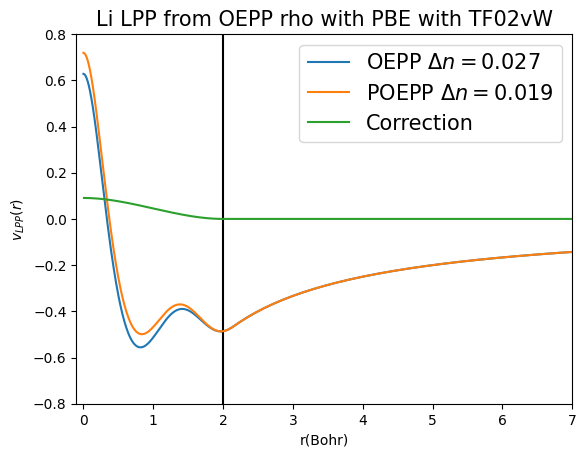

In [41]:
import matplotlib.pyplot as plt
plt.plot(r,vl, label='OEPP $\Delta n = 0.027$')
rcut = 2.0
r1=np.linspace(start=0.01,stop=10,num=1000)
# plt.plot(r,-3/(r+0.1))
#plt.scatter(np.arange(10),np.zeros(10)-4)
plt.vlines(x=rcut,ymin=-1,ymax=1,colors='k')
plt.plot(r,v, label='POEPP $\Delta n = 0.019$')
plt.plot(r1,delta_pp(r1,rcut,a), label='Correction')
plt.ylim(-0.8,0.8)
plt.xlim(-0.1,7)
plt.xlabel('r(Bohr)')
plt.ylabel('$v_{LPP}(r)$')
plt.legend(fontsize=15)
plt.title('Li LPP from OEPP rho with PBE with TF02vW', fontsize=15)

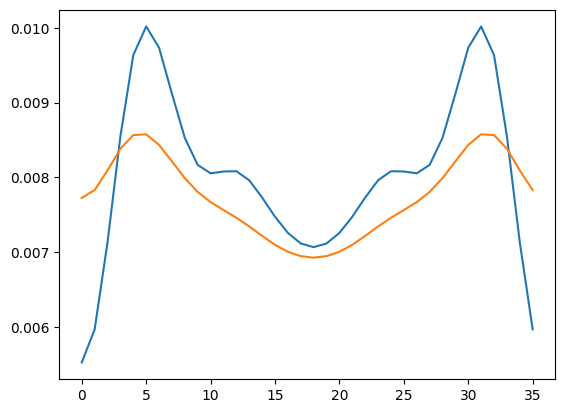

In [70]:
plt.plot(rho[0,0,:].ravel())
plt.plot(rho_ks[0,0,:].ravel())